In [137]:
#importações

#bibliotecas para manipulação de dados
import pandas as pd
import numpy as np
import math

# bibliotecas para visualização
import matplotlib.pyplot as plt

#modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#definição de funções

#função que calcula a entropia do conjunto de dados
def calculate_entropy(dataset, target, decimal_places=4): #dataset: conjunto de dados em formato DataFrame, target: atributo alvo, decimal_places: casas decimais
    entropy = 0
    for target_value in sorted(dataset[target].unique()): #para cada valor do atributo alvo
        target_value_count = dataset[target].value_counts()[target_value] #conta o número de ocorrências do valor do atributo alvo
        target_value_probability = target_value_count / len(dataset) #calcula a probabilidade do valor do atributo alvo
        entropy += -target_value_probability * np.log2(target_value_probability) #soma a entropia do valor do atributo alvo
    return round(entropy, decimal_places) #retorna a entropia do conjunto de dados

#função que calcula o ganho de informação de um atributo
def calculate_information_gain(dataset, target, attribute, verbose=False, decimal_places=4): #dataset: conjunto de dados em formato DataFrame, target: atributo alvo, attribute: atributo, verbose: exibe informações adicionais, decimal_places: casas decimais
    information_gain = calculate_entropy(dataset, target) #calcula a entropia do conjunto de dados
    for attribute_value in sorted(dataset[attribute].unique()): #para cada valor do atributo
        if verbose: 
            print('attribute: {}'.format(attribute_value))
        attribute_value_count = dataset[attribute].value_counts()[attribute_value] #conta o número de ocorrências do valor do atributo
        if verbose:
            print('total occurrences: {}'.format(attribute_value_count))
        attribute_value_probability = attribute_value_count / len(dataset) #calcula a probabilidade do valor do atributo
        if verbose:
            print('probability: {}'.format(attribute_value_probability))
        information_gain -= attribute_value_probability * calculate_entropy(dataset[dataset[attribute] == attribute_value], target) #subtrai a entropia do valor do atributo
        if verbose:
            print('entropy: {}'.format(calculate_entropy(dataset[dataset[attribute] == attribute_value], target)))
            print('')

    if verbose:
        print('information gain: {}'.format(information_gain)) 
    
    return round(information_gain, decimal_places) #retorna o ganho de informação do atributo

- O conjunto de dados foi feito com base em questionário aplicado a 170 caisais.
- O questionario é inspirado no metodo Gottman de terapia de casais.
- Cada pergunta é avaliada em uma escala de 0 a 4, com 0 representando a avaliação mais baixa e 4 a avaliação mais alta.
- A última categoria indica se o casal se divorciou.

In [138]:
#dicionario com a pergunta correspondente a de cada atributo
question_dict = {
    "question_1": "Se um de nós pedir desculpas quando nossa discussão piorar, a discussão termina.",
    "question_2": "Sei que podemos ignorar nossas diferenças, mesmo que as coisas fiquem difíceis às vezes.",
    "question_3": "Quando precisamos, podemos recomeçar nossas discussões com meu cônjuge e corrigi-las.",
    "question_4": "Quando discuto com meu cônjuge, entrar em contato com ele eventualmente funcionará.",
    "question_5": "O tempo que passo com minha esposa é especial para nós.",
    "question_6": "Não temos tempo em casa como parceiros.",
    "question_7": "Somos como dois estranhos que compartilham o mesmo ambiente em casa, em vez de uma família.",
    "question_8": "Eu aproveito nossas férias com minha esposa.",
    "question_9": "Eu gosto de viajar com minha esposa.",
    "question_10": "A maioria de nossos objetivos é comum ao meu cônjuge.",
    "question_11": "Acredito que um dia, olhando para trás, verei que meu cônjuge e eu estivemos em harmonia um com o outro.",
    "question_12": "Meu cônjuge e eu temos valores semelhantes em relação à liberdade pessoal.",
    "question_13": "Meu cônjuge e eu temos um senso de entretenimento semelhante.",
    "question_14": "A maioria de nossos objetivos em relação a pessoas (filhos, amigos, etc.) é a mesma.",
    "question_15": "Nossos sonhos com meu cônjuge são semelhantes e harmoniosos.",
    "question_16": "Somos compatíveis com meu cônjuge sobre o que o amor deve ser.",
    "question_17": "Compartilhamos as mesmas opiniões sobre ser feliz em nossa vida com meu cônjuge.",
    "question_18": "Meu cônjuge e eu temos ideias semelhantes sobre como o casamento deve ser.",
    "question_19": "Meu cônjuge e eu temos ideias semelhantes sobre como os papéis devem ser no casamento.",
    "question_20": "Meu cônjuge e eu temos valores semelhantes em relação à confiança.",
    "question_21": "Sei exatamente do que minha esposa gosta.",
    "question_22": "Sei como meu cônjuge quer ser cuidado quando está doente.",
    "question_23": "Sei a comida favorita do meu cônjuge.",
    "question_24": "Posso dizer qual tipo de estresse meu cônjuge está enfrentando em sua vida.",
    "question_25": "Tenho conhecimento do mundo interior do meu cônjuge.",
    "question_26": "Sei quais são as ansiedades básicas do meu cônjuge.",
    "question_27": "Sei quais são as fontes atuais de estresse do meu cônjuge.",
    "question_28": "Sei quais são as esperanças e desejos do meu cônjuge.",
    "question_29": "Conheço muito bem meu cônjuge.",
    "question_30": "Conheço os amigos do meu cônjuge e seus relacionamentos sociais.",
    "question_31": "Sinto-me agressivo quando discuto com meu cônjuge.",
    "question_32": "Ao discutir com meu cônjuge, geralmente uso expressões como 'você sempre' ou 'você nunca'.",
    "question_33": "Posso fazer declarações negativas sobre a personalidade do meu cônjuge durante nossas discussões.",
    "question_34": "Posso usar expressões ofensivas durante nossas discussões.",
    "question_35": "Posso insultar meu cônjuge durante nossas discussões.",
    "question_36": "Posso ser humilhante quando discutimos.",
    "question_37": "Minha discussão com meu cônjuge não é calma.",
    "question_38": "Odeio a maneira como meu cônjuge abre um assunto.",
    "question_39": "Nossas discussões frequentemente ocorrem de repente.",
    "question_40": "Estamos apenas começando uma discussão antes que eu saiba o que está acontecendo.",
    "question_41": "Quando falo com meu cônjuge sobre algo, minha calma quebra repentinamente.",
    "question_42": "Quando discuto com meu cônjuge, simplesmente saio e não digo uma palavra.",
    "question_43": "Na maioria das vezes, fico em silêncio para acalmar um pouco o ambiente.",
    "question_44": "Às vezes, acho que é bom para mim sair de casa por um tempo.",
    "question_45": "Prefiro ficar em silêncio do que discutir com meu cônjuge.",
    "question_46": "Mesmo que eu esteja certo na discussão, fico em silêncio para magoar meu cônjuge.",
    "question_47": "Quando discuto com meu cônjuge, fico em silêncio porque tenho medo de não conseguir controlar minha raiva.",
    "question_48": "Sinto que estou certo em nossas discussões.",
    "question_49": "Não tenho nada a ver com o que fui acusado.",
    "question_50": "Na verdade, não sou o culpado pelo que estou sendo acusado.",
    "question_51": "Não sou o errado em problemas em casa.",
    "question_52": "Não hesitaria em dizer ao meu cônjuge sobre sua inadequação.",
    "question_53": "Quando discuto, lembro meu cônjuge de sua inadequação.",
    "question_54": "Não tenho medo de dizer ao meu cônjuge sobre sua incompetência."
}

In [139]:
#carregamento do dataset
divorce_dataset = pd.read_csv('dataset/divorce.csv', sep=';')
divorce_dataset.head(5)

,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,...,question_46,question_47,question_48,question_49,question_50,question_51,question_52,question_53,question_54,class
0,2,2,4,1,0,0,0,0,0,0,...,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,4,0,0,4,4,4,...,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,1,3,2,1,1,2,...,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,3,...,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,1,0,0,0,0,...,2,1,2,3,2,2,2,1,0,1


Dos 170 casais que foram ouvidos 49,4% (84) estavam divorciado e 50,6% (86) não divorciado (casado).

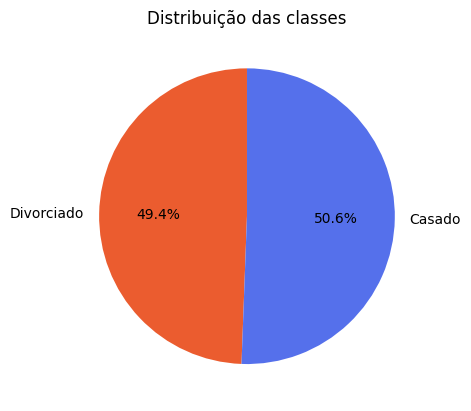

In [140]:
# gráfico de pizza com a distribuição das classes
labels = 'Divorciado', 'Casado'
sizes = [len(divorce_dataset[divorce_dataset['class'] == 1]), len(divorce_dataset[divorce_dataset['class'] == 0])]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#EB5C2F','#5570EB'])
plt.title('Distribuição das classes')
plt.show()

In [141]:
#nome dos atributos
attributes_name_list = divorce_dataset.columns.tolist()[0:-1]

#nome do atributo meta
meta_attribute = divorce_dataset.columns.tolist()[-1]

In [142]:
#entropia total do conjunto de dados
print(calculate_entropy(divorce_dataset, meta_attribute))

0.9999


In [143]:
#calcula o ganho de informação de cada atributo
gain_list = []

for attribute in attributes_name_list:
    gain_list.append(calculate_information_gain(divorce_dataset,meta_attribute,attribute))

gain_df = pd.dataset({'attribute': attributes_name_list, 'gain': gain_list})
gain_df.sort_values(by='gain', ascending=False, inplace=True, ignore_index=True)
gain_df['question'] = [question_dict[x] for x in gain_df['attribute']]

#top 15 atributos com maior ganho de informação
gain_df.head(15)

,attribute,gain,question
0,question_18,0.9119,Meu cônjuge e eu temos ideias semelhantes sobr...
1,question_20,0.8970,Meu cônjuge e eu temos valores semelhantes em ...
2,question_40,0.8900,Estamos apenas começando uma discussão antes q...
3,question_17,0.8821,Compartilhamos as mesmas opiniões sobre ser fe...
4,question_19,0.8715,Meu cônjuge e eu temos ideias semelhantes sobr...
5,question_11,0.8683,"Acredito que um dia, olhando para trás, verei ..."
6,question_9,0.8545,Eu gosto de viajar com minha esposa.
7,question_16,0.8369,Somos compatíveis com meu cônjuge sobre o que ...
8,question_15,0.8232,Nossos sonhos com meu cônjuge são semelhantes ...
9,question_26,0.8223,Sei quais são as ansiedades básicas do meu côn...


<Figure size 1500x1000 with 0 Axes>

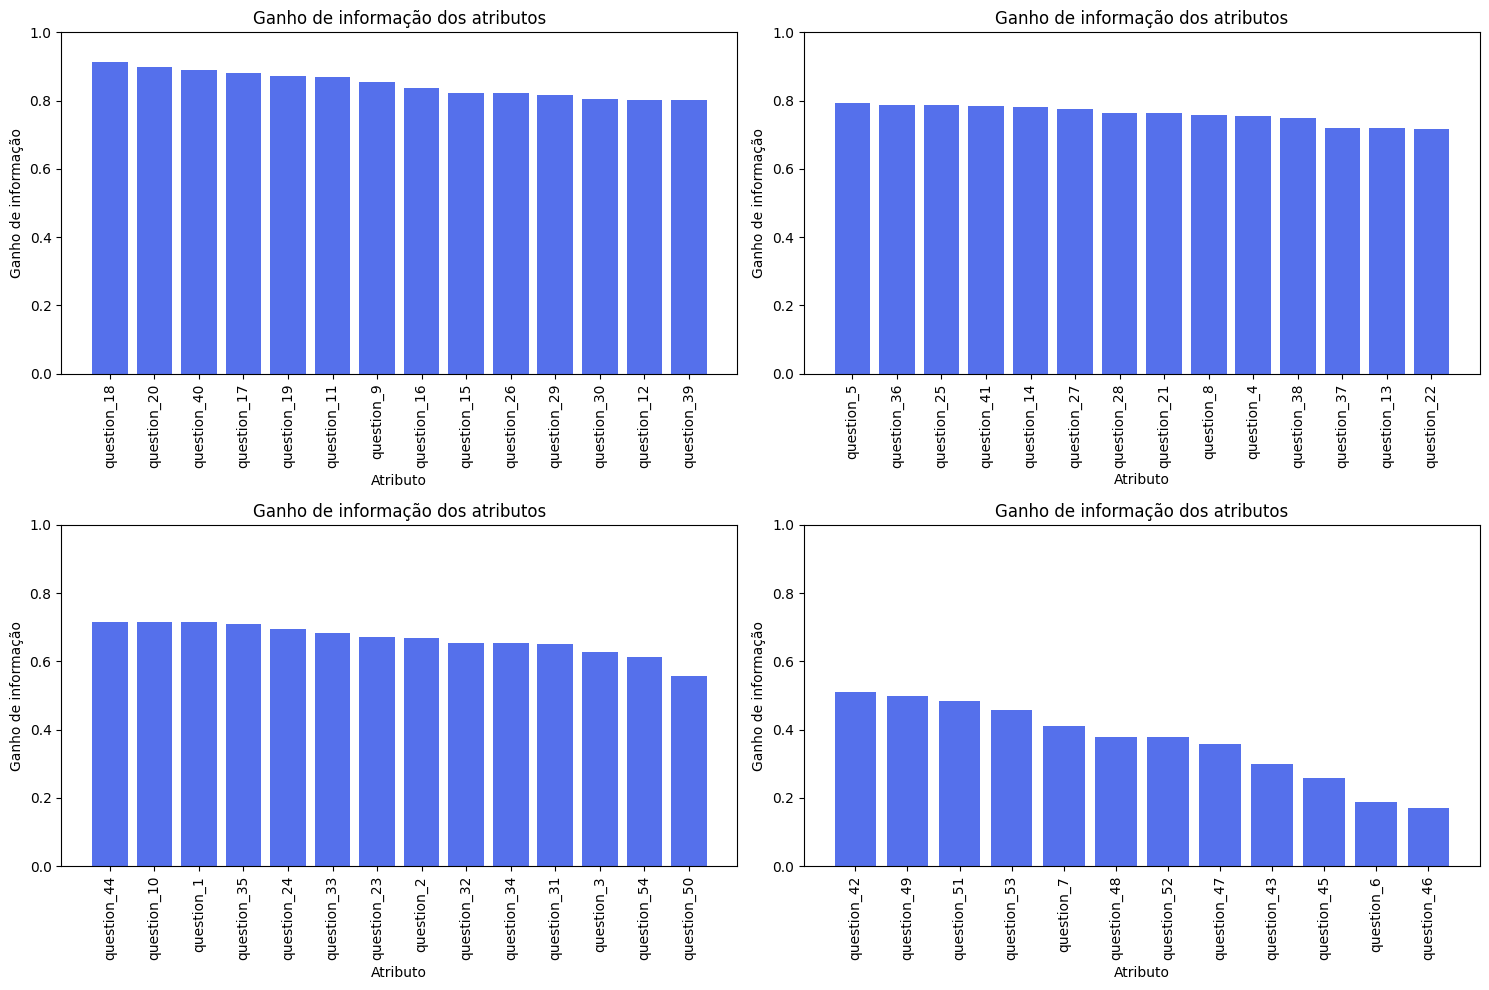

In [160]:
# gráfico de barras com o ganho de informação de cada atributo

rows = 2
col = 2

fig, axes = plt.subplots(rows, col, figsize=(15, 10))

init = 0
step = math.ceil(len(gain_df) // (rows * col)) + 1

for i, ax in enumerate(axes.flat):
    start = i * step
    end = min(start + step, len(gain_df))
    
    ax.bar(gain_df['attribute'][start:end], gain_df['gain'][start:end], color='#5570EB')
    ax.set_xticks(range(len(gain_df['attribute'][start:end])))
    ax.set_xticklabels(gain_df['attribute'][start:end], rotation=90)
    ax.set_xlabel('Atributo')
    ax.set_ylabel('Ganho de informação')
    ax.set_ylim(0, 1)
    ax.set_title('Ganho de informação dos atributos')

plt.tight_layout()
plt.show()
